### Used Car price prediction
Dataset: [Used Car Prices](https://www.kaggle.com/datasets/sujay1844/used-car-prices)

In [264]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [265]:
file = os.path.join(os.getcwd(), os.pardir, 'data', 'used_car_prices', 'used_car_prices.csv')

In [266]:
df = pd.read_csv(file)

## Used Car price prediction

The target variable in the dataset is 'Price' which give the ***price*** of the car (units: 100,000 INR)

**Plan of Action:**
1. Split data set in to test and train dataset
2. High-level observations on the dataset:
    * Understand the dimensions and datatypes in the dataset
    * Check for Missing values & duplicate rows in the dataset
    * Check basis descriptive statistics for numerical variabels in the dataset and check for any outliers
    * Check values counts for categorical variables
    * Check for any inconsistent values in the data set
    * Perform type conversions where necessary
3. Explore features in the dataset - Visualize, plot relationships between variables 
4. Pre-process the dataset
    * Outlier treatment
    * Cleaning inconsistent values
5. Feature Engineering:
    * extract brand name from 'Name' column
    * extract numerical values from applicable columns
6. Create a data pipeline to pre-process the dataset:
    * Missing value imputation
    * Adding polynomial features 
    * Feature scaling
    * convert categorical varibale using OneHotEncoder
    * try OrdinalEncoder for Owner_type column
8. Select a set of candidate models for the prediction
9. Hyperparameter Tuning: For each of the candidate models, select the hyperparameters using Cross-validation
10. Model selection: Based on selected hyper parameters, choose the best model with the lowest CV error
11. Estimate the Generalization error on the Test data set

In [267]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=230)

In [268]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677 entries, 4755 to 4864
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         4677 non-null   int64  
 1   Name               4677 non-null   object 
 2   Location           4677 non-null   object 
 3   Year               4677 non-null   int64  
 4   Kilometers_Driven  4677 non-null   int64  
 5   Fuel_Type          4677 non-null   object 
 6   Transmission       4677 non-null   object 
 7   Owner_Type         4677 non-null   object 
 8   Mileage            4676 non-null   object 
 9   Engine             4647 non-null   object 
 10  Power              4647 non-null   object 
 11  Seats              4646 non-null   float64
 12  New_Price          665 non-null    object 
 13  Price              4677 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 548.1+ KB


In [269]:
df_train.head()
# df.duplicated().sum()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
4755,4896,Honda Brio V MT,Pune,2012,59000,Petrol,Manual,First,19.4 kmpl,1198 CC,86.8 bhp,5.0,NaN,3.25
3780,3904,Maruti Swift Dzire VXI,Kolkata,2014,45000,Petrol,Manual,First,19.1 kmpl,1197 CC,85.8 bhp,5.0,NaN,3.99
947,980,Skoda Rapid 1.6 MPI Ambition Plus,Kochi,2014,33855,Petrol,Manual,First,15.0 kmpl,1598 CC,103.6 bhp,5.0,NaN,5.09
3799,3923,Hyundai Accent GLE,Hyderabad,2004,110000,Petrol,Manual,First,13.2 kmpl,1495 CC,94 bhp,5.0,NaN,0.60
4240,4372,Hyundai i20 Asta Option 1.4 CRDi,Coimbatore,2016,99362,Diesel,Manual,First,22.54 kmpl,1396 CC,88.73 bhp,5.0,NaN,7.03


### High-level observations on the dataset

1. Dimensions: Total of 14 features and 5847 samples in the data
2. The first column 'Unnamed: 0' looks to be an unnecessary column, we may just need to drop it
3. Mileage, Engine, Power can be converted into numerica attributes
    * The units are hard coded and could be different. Example mileage column has values in kmpl and km/kg
4. Missing values: Engine, Power, Seats, New_price seem to be having missing values
    * Need to cehck for missing values in the other columms as well, since they could be coded using special values
    * There are no duplicate rows in the dataset 
    * Also, given that there are about 30 (~1%) of rows with missing values, we can just drop them and proceed
5. Owner_type could be treated as an ordinal variable
6. Given the objective of this exercise is to predict the used car price and the high% of missing values, we may drop the New_price column  

In [270]:
df_train.describe()

,Unnamed: 0,Year,Kilometers_Driven,Seats,Price
count,4677.00000,4677.000000,4677.000000,4646.000000,4677.000000
mean,3011.30789,2013.464186,57387.140475,5.278089,9.686171
std,1740.03813,3.185901,38588.259580,0.792145,11.191432
min,1.00000,1998.000000,171.000000,2.000000,0.440000
25%,1489.00000,2012.000000,33554.000000,5.000000,3.550000
50%,3009.00000,2014.000000,52380.000000,5.000000,5.800000
75%,4511.00000,2016.000000,72450.000000,5.000000,10.490000
max,6018.00000,2019.000000,775000.000000,10.000000,160.000000


### Numerical attributes
1. The Unnamed column maybe an old idex column and can be dropped
2. The earliest car manufacturing year is 1998 and the latest is 2019
    * This data does not consist of any vintage cars
3. There are outliers in the Kilometers_driven and Price columns
    * For the price column, the max price is INR 1.6MN and the lowest price car is INR 44K
    * We may want to convert the mileage, engine and power variables after converting them to numerical

In [271]:
def get_cat_cols():
    cat_cols = df_train.dtypes[df_train.dtypes =='object']
    return cat_cols.index

# for col in get_cat_cols():
#     print(df_train[col].value_counts())

### Categorical attributes
1. The 'Brand' of the vehicle can be extracted from the Name column and caan be used for the price prediction
2. The data consists of prices from 11 different locations
3. There are three distinct fuel types: Petrol, Diesel and Electric
    * There are only 2 sample pertaining to elevtric vehicle and its better to drop them from the dataset
4. We can split the units from the Mileage Engine & power variables to extract the numerical values 
5. We can drop the New_price column

### Cleaning the dataset:

Based on the above oservations of Numeric and categorical variables, we take the below steps to clean the dataset
1. Drop the first column 'Unnamed: 0' and the 'New_Price' column
2. Drop rows with fuel_type=='Electric'
3. Process & convert Mileage, Engine, Power into numerical attributes
4. Convert the Year column to datetime
5. Convert remaining text columns into categorical variables

In [272]:
df_train = df_train.drop(['Unnamed: 0', 'New_Price'], axis=1)
df_train = df_train[df_train.Fuel_Type != 'Electric']
df_train = df_train.dropna(how='any')

## Checking for units in the Mileage column
df_train.Mileage.map(lambda x: x.split()[1]).value_counts()
df_train[df_train.Mileage.str.contains('km/kg')]
# There are only 3 rows with km/kg units. Given the small number, we candrop the three rows and proceed 
df_train = df_train[~df_train.Mileage.str.contains('km/kg')]
df_train['Mileage'] = df_train.Mileage.map(lambda x: x.strip().split()[0]).astype(np.float64)


## Checking for units in the Engine column
df_train.Engine.map(lambda x: x.strip().split()[1]).value_counts() # Need to select non-null rows is they were not already dropped
# All the units are in CC. hence we can safely split the column to extract numeric values.
# A problem could arise if the test-set has units other than CC. It could break the pre-processing pipeline
df_train['Engine'] = df_train.Engine.map(lambda x: x.strip().split()[0]).astype(np.float64)


## Checking for units in the Power column
df_train.Power.map(lambda x: x.strip().split()[1]).value_counts() # Need to select non-null rows is they were not already dropped
# All the units are in bhp. hence we can safely split the column to extract numeric values.
# Similar to Engine-CC, a problem could arise if the test-set has units other than bhp.
df_train['Power'] = df_train.Power.map(lambda x: x.strip().split()[0]).astype(np.float64)



In [273]:
df_train[get_cat_cols()] = df_train[get_cat_cols()].astype('category')
df_train['Year'] = pd.to_datetime(df_train.Year, format='%Y')

In [274]:
df_train.describe()

,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,4642.000000,4642.000000,4642.000000,4642.000000,4642.000000,4642.000000
mean,57294.112882,18.232355,1630.465532,114.101831,5.278328,9.704748
std,38600.886333,4.279023,598.029765,53.692101,0.792444,11.207178
min,171.000000,0.000000,624.000000,34.200000,2.000000,0.440000
25%,33497.000000,15.290000,1198.000000,78.900000,5.000000,3.600000
50%,52282.500000,18.200000,1497.000000,98.600000,5.000000,5.805000
75%,72176.500000,21.100000,1991.000000,140.000000,5.000000,10.475000
max,775000.000000,28.400000,5998.000000,552.000000,10.000000,160.000000


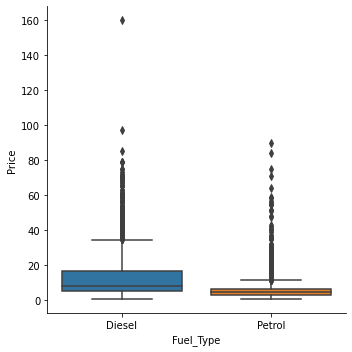

In [275]:
sns.catplot(data=df_train, x='Fuel_Type', y='Price', kind='box')

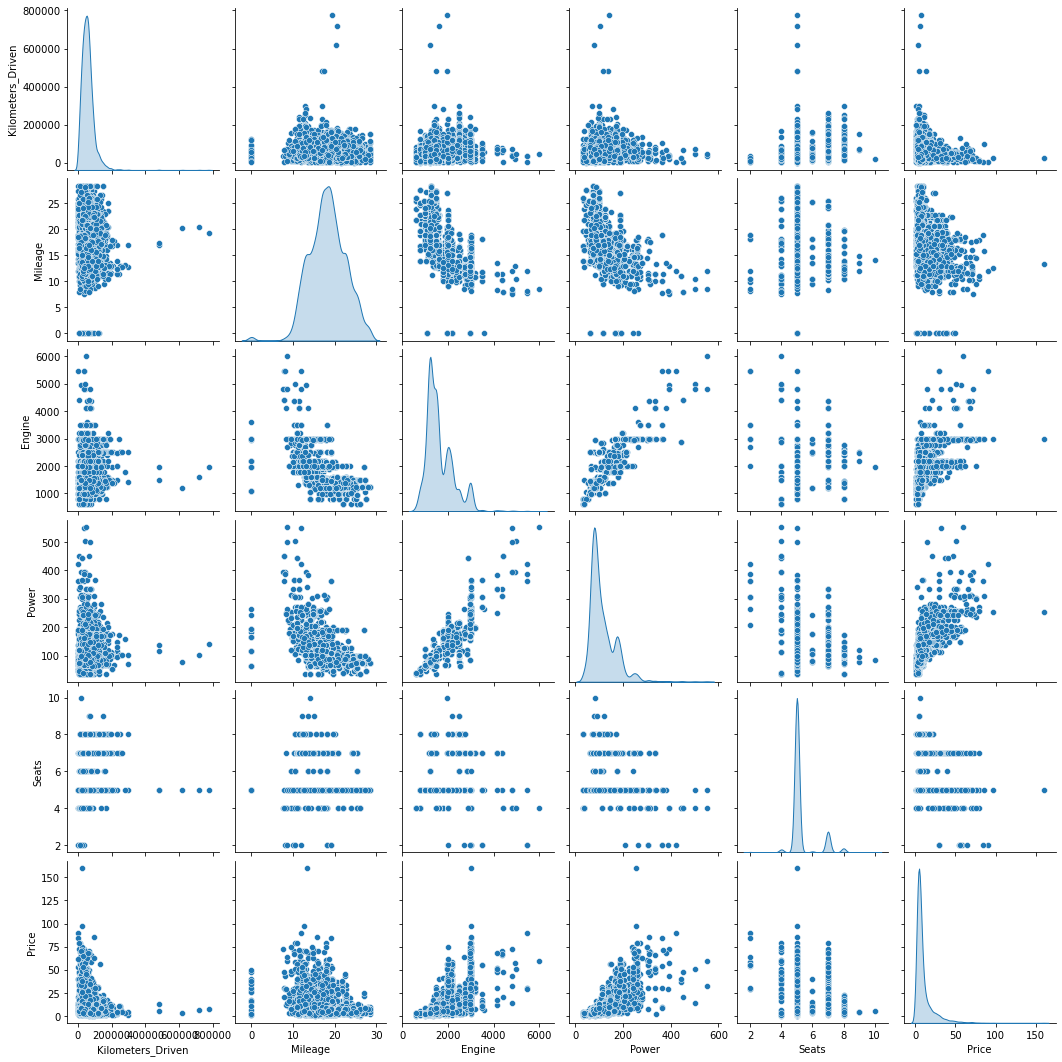

In [276]:
sns.pairplot(data=df_train
            , diag_kind='kde')

### Numerical attributes after cleaning
1. The attribute Kilometers_Driven has a wide range of values, including a few outliers and would definitely need scaling
    * We can use winsorization to replace outliers with 99% values
2. The Mileage attribute has a few values as zero. These are possibly missing values with 0 being used as the placeholder for missing values
3. There is one data point in the Price column which is a clear outlier and could significantly affect the price prediction. Hence we can consider dropping this data point 
3. The Engine variable has a multi-modal distribution
4. Power and Engine varible seem to have a positive linear correlation
5. There are definitely a few non-linear relationsships amongst attributes such as Engine vs Mileage, Power vs Price, Price vs Kilometers_Driven etc. We can try experimenting with polynomial features.

In [277]:
# Winsorization on Kilometers_Driven
kms_winsr = np.quantile(df_train.Kilometers_Driven, 0.99)
df_train.Kilometers_Driven = df_train.Kilometers_Driven.clip(upper=kms_winsr)

# Removing Price variable outlier from the data set
max_price = df_train.Price.max()
df_train = df_train[df_train.Price != max_price]

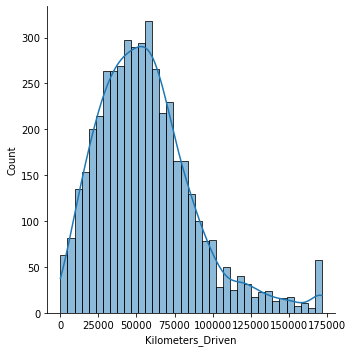

In [278]:
sns.displot(data=df_train, x='Kilometers_Driven', kde=True)

### Feature Engineering

* We want to create the below two variables to better predict the price of the used vehicle:
    * Manufacturer: The Brand of the vehicle can be xtracted from the first word in the Name column
    * The number of years since manufacturing year can be computed as difference between current date and Year column

In [285]:
df_train.loc[:,'Manuf'] = df_train.Name.map(lambda x: x.strip().split()[0]).astype('category')
df_train.loc[:,'Model_years'] = (dt.datetime.today() - df_train['Year'])
df_train.loc[:,'Model_years'] = df_train.loc[:,'Model_years'].dt.days.astype(np.float64)
df_train.loc[:,'Owner_Type'] = df_train.loc[:,'Owner_Type'].astype(str)

C:\Users\sande\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [280]:
df_train

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Manuf,Model_years
4755,Honda Brio V MT,Pune,2012-01-01,59000.0,Petrol,Manual,First,19.40,1198.0,86.80,5.0,3.25,Honda,4389.0
3780,Maruti Swift Dzire VXI,Kolkata,2014-01-01,45000.0,Petrol,Manual,First,19.10,1197.0,85.80,5.0,3.99,Maruti,3658.0
947,Skoda Rapid 1.6 MPI Ambition Plus,Kochi,2014-01-01,33855.0,Petrol,Manual,First,15.00,1598.0,103.60,5.0,5.09,Skoda,3658.0
3799,Hyundai Accent GLE,Hyderabad,2004-01-01,110000.0,Petrol,Manual,First,13.20,1495.0,94.00,5.0,0.60,Hyundai,7311.0
4240,Hyundai i20 Asta Option 1.4 CRDi,Coimbatore,2016-01-01,99362.0,Diesel,Manual,First,22.54,1396.0,88.73,5.0,7.03,Hyundai,2928.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4873,Honda Jazz VX Diesel,Hyderabad,2017-01-01,17151.0,Diesel,Manual,First,27.30,1498.0,98.60,5.0,8.40,Honda,2562.0
5650,Skoda Superb 1.8 TSI,Pune,2010-01-01,35102.0,Petrol,Automatic,First,12.60,1798.0,161.60,5.0,5.50,Skoda,5119.0
4367,Tata Nano XTA,Bangalore,2016-01-01,29000.0,Petrol,Automatic,First,21.90,624.0,37.48,4.0,2.80,Tata,2928.0
4656,BMW 3 Series Luxury Line,Kochi,2018-01-01,21936.0,Diesel,Automatic,First,21.76,1995.0,190.00,5.0,37.92,BMW,2197.0


### Data preparation

We take the following steps in order to prepare the dataset for model building
1. Numerical Attributes:
    * Impute missing values (=0.0) in Mileage column with the median value
    * Add polynomial features to the dataset (degree=2)
    * Use standard scaler
2. Categorical Attributes:
    * Use OrdinalEncoder on Owner_Type variable
    * Use OneHotEncoder on the rest of the variables

In [299]:
### Building a data preparation pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector

num_pipeline = Pipeline([('med_imputer', SimpleImputer(missing_values=0.0, strategy='median'))
                         , ('poly', PolynomialFeatures(degree=2, include_bias=False))
                         , ('fe_scaler', StandardScaler())
                         ,    
                    ])
ord_pipeline = Pipeline([('ord_encoder', OrdinalEncoder(categories=[['First', 'Second', 'Third', 'Fourth & Above'], ]))])

cat_pipeline = Pipeline([('oh_encoder', OneHotEncoder())])

full_pipeline = ColumnTransformer([('drop', 'drop', ['Name', 'Year'])
                                   , ('num_pipeline', num_pipeline, selector(dtype_include=np.number))
                                   , ('ord_pipeline', ord_pipeline, selector(dtype_include='object'))
                                   , ('cat_pipeline', cat_pipeline, selector(dtype_include='category'))
                    ])

In [302]:
X_train = df_train[[col for col in df_train.columns if col != 'Price']]
y_train = df_train['Price']
full_pipeline.fit(X_train)
X_train_prepared = full_pipeline.transform(X_train)
features = full_pipeline.get_feature_names_out()

### Building a predictive model

This is a regression problem with 'Price' being the target variable

List of models to be used:
1. Linear Regression:
    * Train using Normal Equations
    * Train using LinearRegression()
2. Train using SGD Regression:
    * From scratch
    * Un-regularized Linear Regression
    * Ridge
    * Lasso
    * ElasticNet
3. DecisionTree Regression

In [441]:
# Fitting a Linear Regression model using Normal Equations

from numpy.linalg import inv, pinv, det, cond 
from sklearn.base import BaseEstimator, TransformerMixin

class NormEqLinearRegression(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
        
    def fit(self, X_train_prepared, y_train):
        X = np.c_[np.ones((X_train_prepared.shape[0], 1)), X_train_prepared.toarray()] # add a constant to the input dat
        X = np.matrix(X)
        y = np.matrix(y_train)
        params = X.T.dot(X)
        if det(params) > 10e-10:
            params = inv(params)
            params = params@(X.T)
            params = params@y.T
            self.intercept_ = params[0]
            self.coef_ = params[1:]
        else:
            self.coef_ = None
            print("Determinant very small. Inverse not accurate")
        return self
        
    def predict(self, X_new):
        if self.coef_:
            y_preds = X_new.dot(self.coef_)+self.intercept_
            return np.asarray(y_preds) 
        else:
            print("Determinant very small. Inverse not accurate")


In [442]:
norm_lin_reg = NormEqLinearRegression()
norm_lin_reg.fit(X_train_prepared, y_train)
y_preds_norm_linreg = norm_lin_reg.predict(X_train_prepared)

# Evaluating predictons
from sklearn.metrics import mean_squared_error

# mse_norm_linreg = mean_squared_error(y_train, y_preds_norm_linreg)
# rmse_norm_linreg = np.sqrt(mse_norm_linreg)
# mse_norm_linreg

Inverse not accurate


In [306]:
from sklearn.linear_model import LinearRegression

# Fitting the model and predicting on training data
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
y_preds_linreg = lin_reg.predict(X_train_prepared)

# Evaluating predictons
from sklearn.metrics import mean_squared_error

mse_linreg = mean_squared_error(y_train, y_preds_linreg)
rmse_linreg = np.sqrt(mse_linreg)
rmse_linreg

1.460340464100517